<h1> Pontifícia Universidade Católica de Minas Gerais </h1>
</br>
<p> Projeto Integrado: <b> Parada Cardiovascular </b> </p>
</br>
<p> Autor: <b> José Pedro Marcoantonio Morgado </b> </p>
</br>
<p> O presente notebook, será utilizado para o desenvolvimento dos códigos do projeto. <br>
    Posteriormente, os códigos serão adicionados no documento de texto (Relatório Técnico) a ser entregue, juntamente das explanações referentes a escolha de cada análise/método empregado.</p>

<h3> Funções </h3>

In [1]:
def _add_graph_info(x_label, y_label, title):
    plt.xlabel(x_label);
    plt.ylabel(y_label);
    plt.title(title);

In [2]:
def plot_categorico(df, col_x):
    print_cat = df.groupby(by=col_x, as_index=False).count()
    plt.bar(x=print_cat[col_x], height=print_cat.Age)
    _add_graph_info(col_x, "Quantidade", "Quantidade de Pacientes em {}".format(col_x))
    plt.show()

In [3]:
def ks(df, col_x):
    result = (kstest(df[col_x], 'norm'))
    print(result[1])
    if result[1] < 0.05:
        print('Rejeita a H0 (hipótese nula), dado não é normal', col_x)
    else:
        print('Aceita a H0 (hipótese nula), dado é normal', col_x)

In [4]:
def fill_median(df_x, df_y, col, median_normal=None, median_disease=None):
    df_median = pd.concat([df_x, df_y], axis=1)
    
    if (median_normal == None) & (median_disease == None):
        median_normal  = df_median.loc[(df_median[col]!=0) & 
                                       (df_median['HeartDisease']==0), col].median()
        median_disease = df_median.loc[(df_median[col]!=0) &
                                       (df_median['HeartDisease']==1), col].median()
    
    return (df_median.apply(lambda x : x[col] 
               if x[col] != 0 
               else median_normal 
                    if x['HeartDisease'] == 0 
                    else median_disease,
               axis=1), median_normal, median_disease)

<h3> Importes de Bibliotecas e Dados </h3>

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, mannwhitneyu, chi2_contingency
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
import seaborn as sns

df = pd.read_csv('heart.csv')
df.head(3)
df1 = df.copy()

<h3> Converter variável Categórica para valores numéricos </h3>

In [6]:
df_obj = df.select_dtypes(np.object_).copy()
for i in df_obj.columns.to_list():
    df_obj[i] = df_obj[i].astype('category')
    df_obj[i] = df_obj[i].cat.codes

<h3> Unir os conjuntos de dados </h3>

In [7]:
df = pd.concat([df, df_obj], axis=1)
df = df.loc[:, ~df.columns.duplicated('last')]

In [8]:
df.head(3)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
0,40,140,289,0,172,0.0,0,1,1,1,0,2
1,49,160,180,0,156,1.0,1,0,2,1,0,1
2,37,130,283,0,98,0.0,0,1,1,2,0,2


<h2> Análise Exploratória </h2>

<h3> Sumarização da base </h3>

In [9]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377,0.789760,0.781046,0.989107,0.404139,1.361656
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414,0.407701,0.956519,0.631671,0.490992,0.607056
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000,1.000000,2.000000,1.000000,1.000000,2.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000,1.000000,3.000000,2.000000,1.000000,2.000000


<h3> Avaliar dados Categóricos </h3>

In [10]:
df1['HeartDisease'] = df1['HeartDisease'].map({1: "heart disease", 0: "Normal"})

In [11]:
categorical_columns = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
numeric_columns = ['Age', 'RestingBP', 'MaxHR', 'Cholesterol', 'Oldpeak']

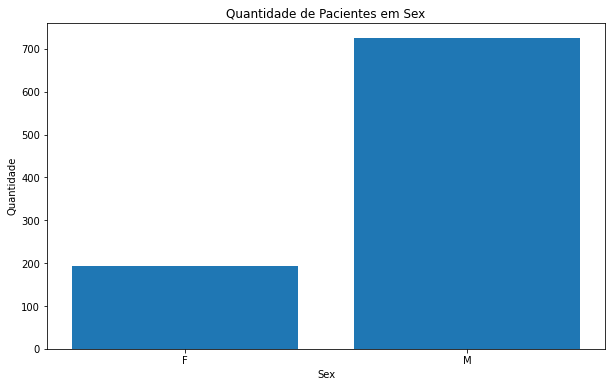

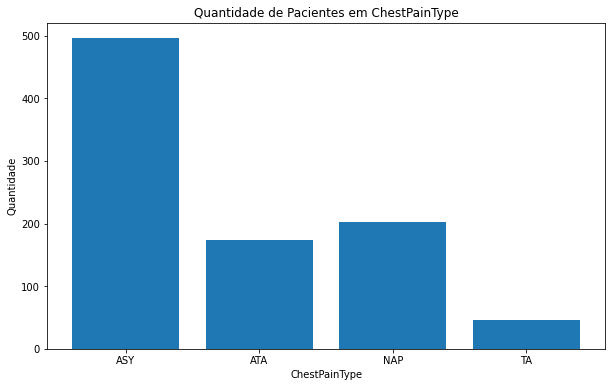

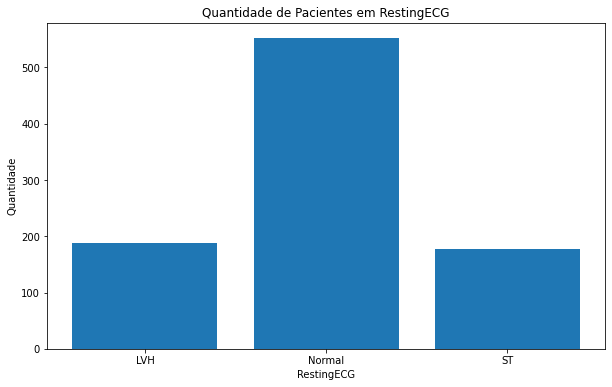

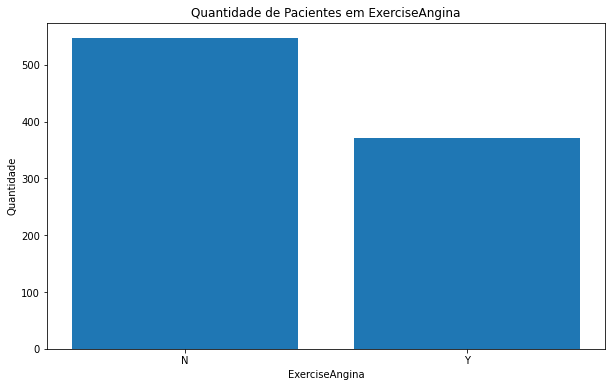

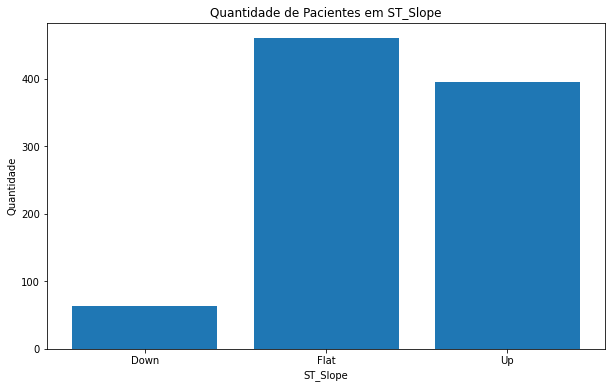

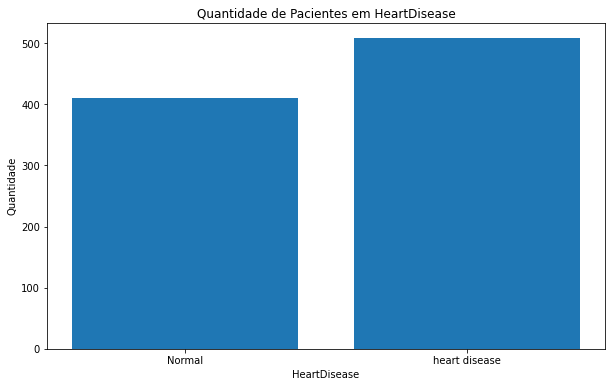

In [12]:
for col in df1.select_dtypes(np.object_):
    plot_categorico(df1, col)

In [13]:
df1["HeartDisease"].value_counts()

heart disease    508
Normal           410
Name: HeartDisease, dtype: int64

<h3> Distribuição dos Dados </h3> 

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


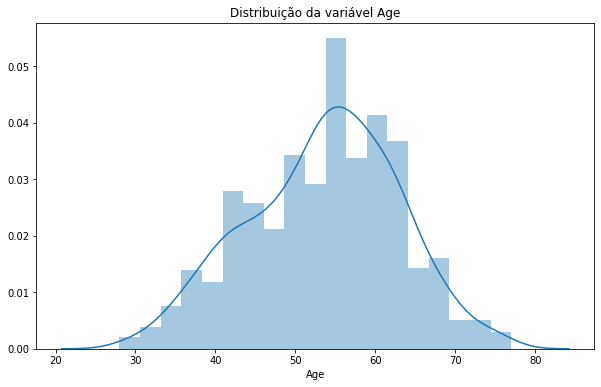

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


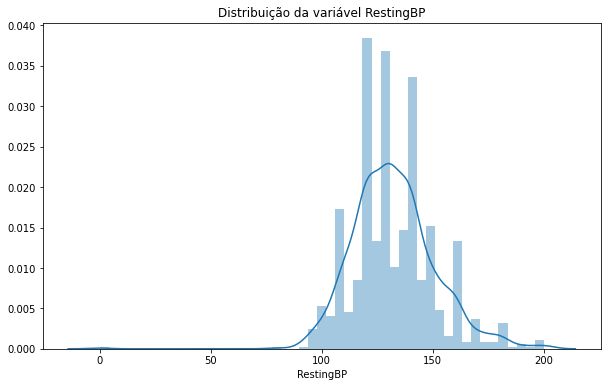

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


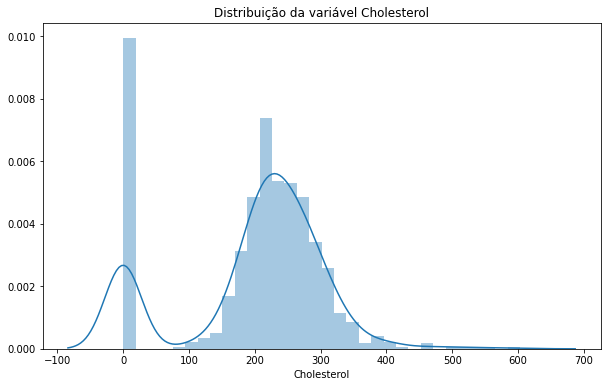

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


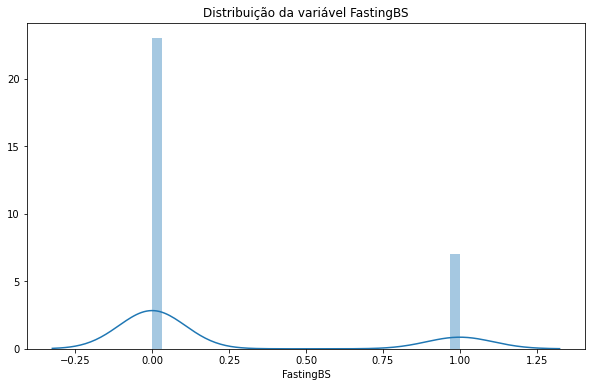

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


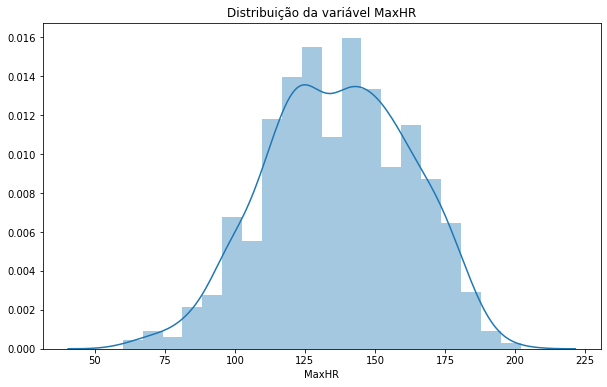

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


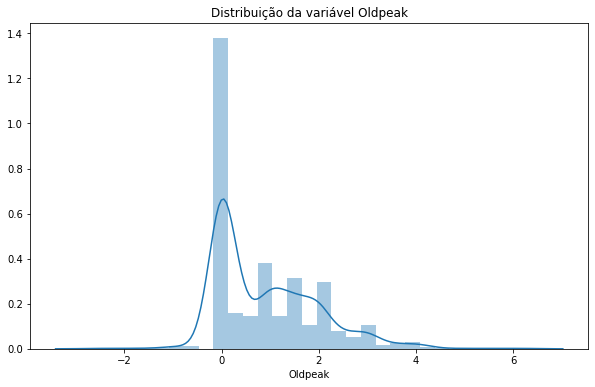

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


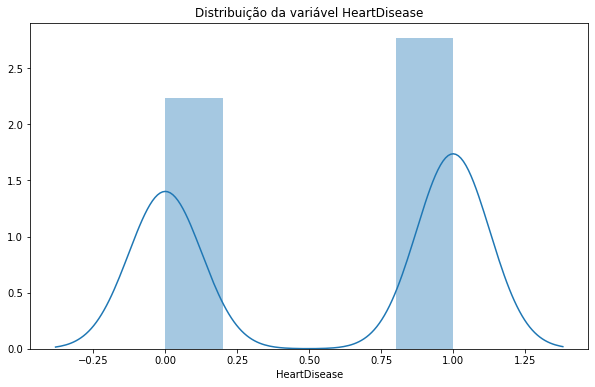

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


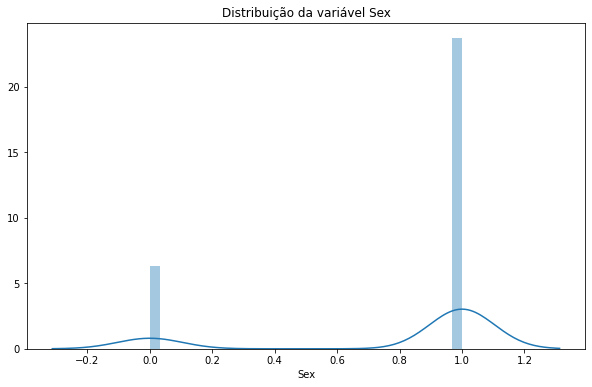

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


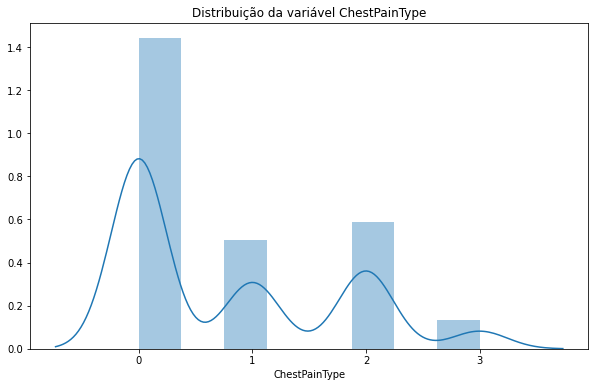

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


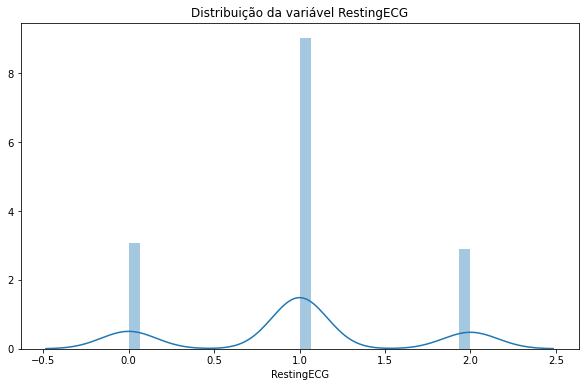

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


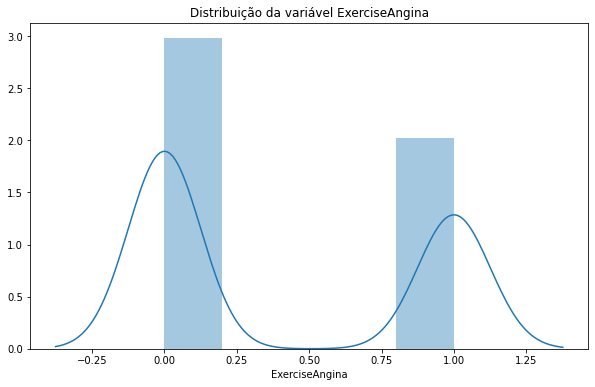

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


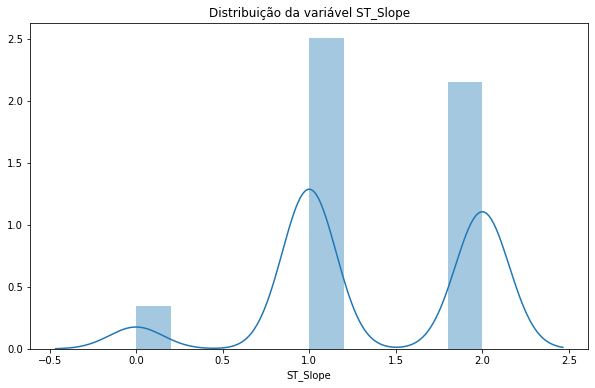

In [14]:
for col in df.columns:
    sns.distplot(df[col])
    _add_graph_info(col, None, "Distribuição da variável {}".format(col))
    plt.show()

<h3> Checar normalidade </h3>

In [15]:
for col in numeric_columns:
    ks(df, col)

0.0
Rejeita a H0 (hipótese nula), dado não é normal Age
0.0
Rejeita a H0 (hipótese nula), dado não é normal RestingBP
0.0
Rejeita a H0 (hipótese nula), dado não é normal MaxHR
0.0
Rejeita a H0 (hipótese nula), dado não é normal Cholesterol
4.2004655072318036e-200
Rejeita a H0 (hipótese nula), dado não é normal Oldpeak


<h3> Análise Multivariada </h3>

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


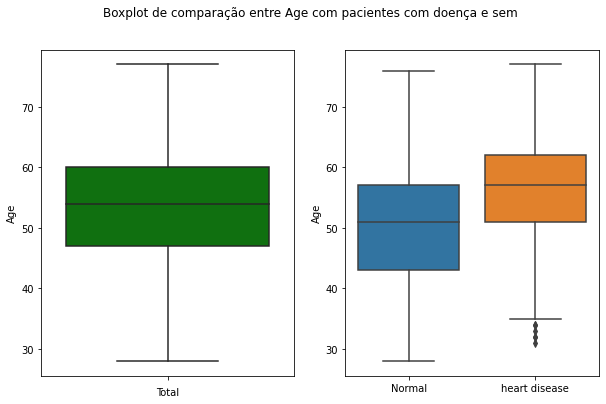

C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


p-valor: 1.805694139029245e-18
Rejeita a hipótese nula, amostras não são iguais para coluna  Age


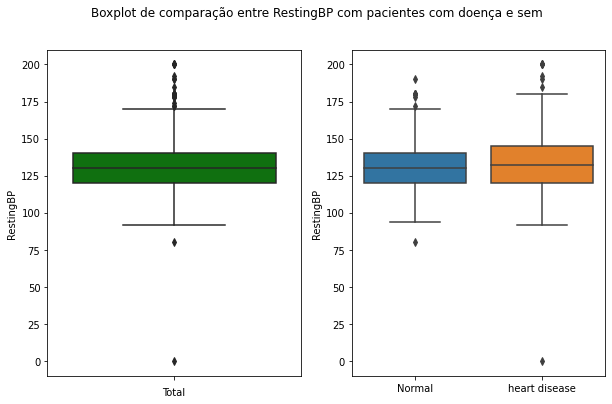

p-valor: 0.0005648075493721535
Rejeita a hipótese nula, amostras não são iguais para coluna  RestingBP


C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


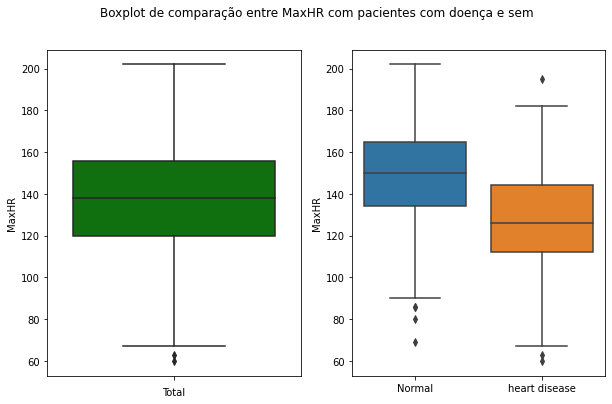

p-valor: 1.5063588719598379e-34
Rejeita a hipótese nula, amostras não são iguais para coluna  MaxHR


C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


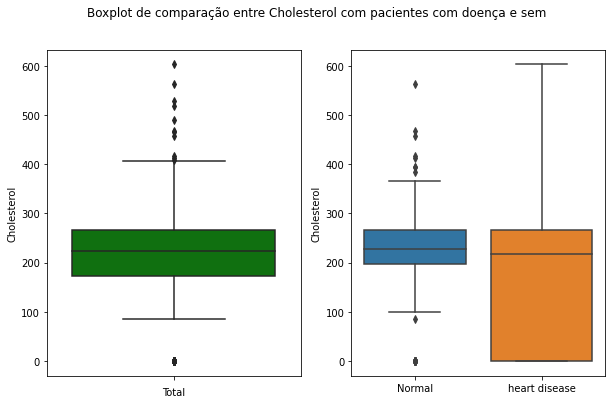

p-valor: 2.2803123635449238e-05
Rejeita a hipótese nula, amostras não são iguais para coluna  Cholesterol


C:\Users\jpzez\Anaconda3\envs\big_data\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


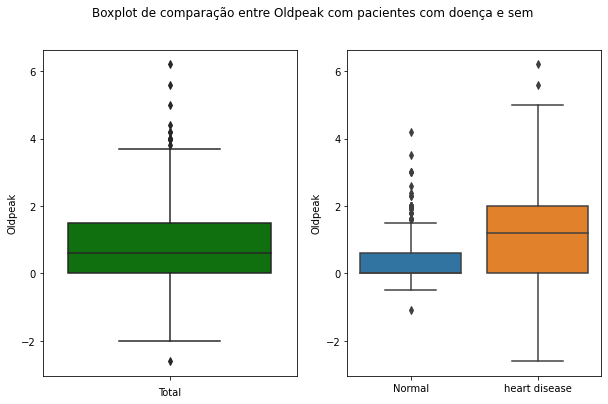

p-valor: 6.767845043438792e-37
Rejeita a hipótese nula, amostras não são iguais para coluna  Oldpeak


In [16]:
for col in numeric_columns:
    fig, axes = plt.subplots(1, 2)
    sns.boxplot(y=col, data=df1, ax=axes[0], color='green')
    sns.boxplot('HeartDisease', col, data=df1, ax=axes[1])
    
    fig.suptitle("Boxplot de comparação entre {} com pacientes com doença e sem".format(col))
    axes[0].set_xlabel('Total')
    
    _add_graph_info(None, col, None)
    plt.show()
    
    normal = df1.loc[df1['HeartDisease'] == 'Normal']
    anormal = df1.loc[df1['HeartDisease'] != 'Normal']
    result = mannwhitneyu(normal[col], anormal[col]).pvalue
    print('p-valor:',  result)
    if result < 0.05:
        print('Rejeita a hipótese nula, amostras não são iguais para coluna ', col)
    else:
        print('Aceita a hipótese nula, amostras são iguais para coluna ', col)

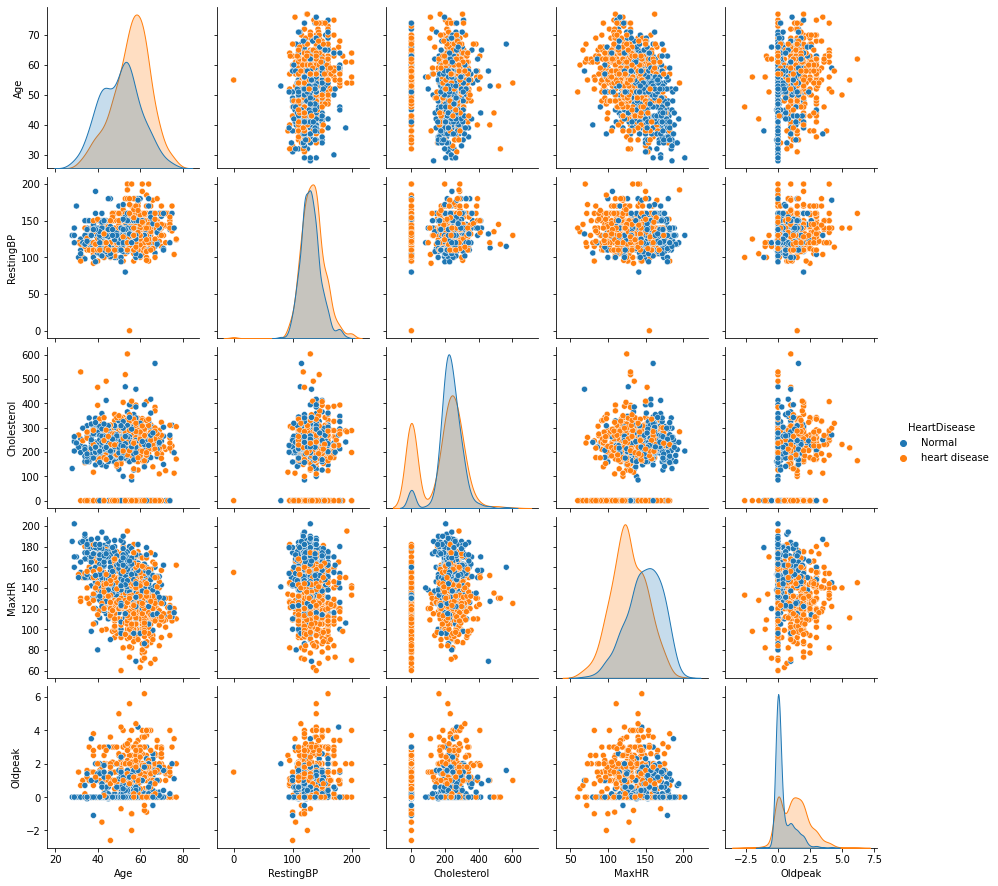

In [17]:
sns.pairplot(df1[df1.columns.drop('FastingBS')], hue='HeartDisease');

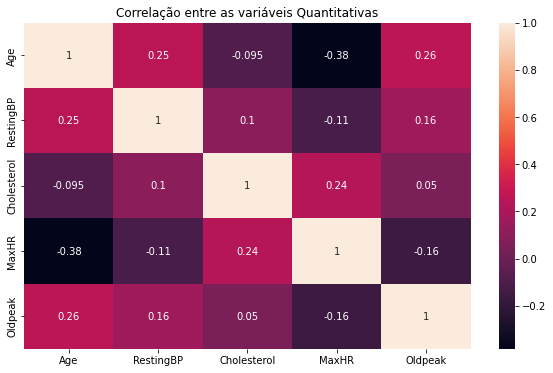

In [18]:
sns.heatmap(df1[df1.columns.drop('FastingBS')].corr(), annot=True);
_add_graph_info(None, None, 'Correlação entre as variáveis Quantitativas')

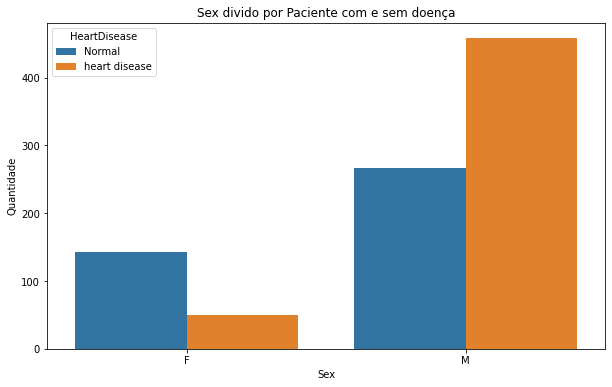

Sex              F    M
HeartDisease           
Normal         143  267
heart disease   50  458
p-valor : 4.597617450809164e-20
Rejeita a hipótese nula, as proporções não são iguais Sex


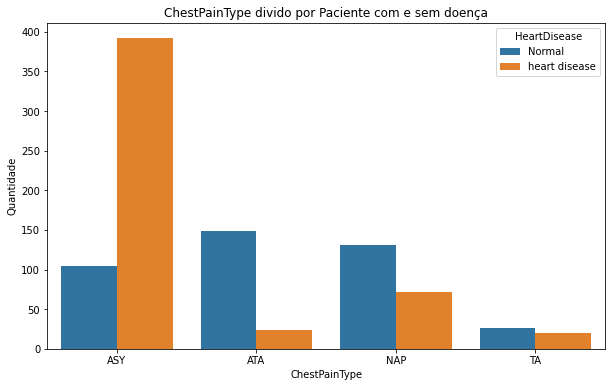

ChestPainType  ASY  ATA  NAP  TA
HeartDisease                    
Normal         104  149  131  26
heart disease  392   24   72  20
p-valor : 8.08372842808765e-58
Rejeita a hipótese nula, as proporções não são iguais ChestPainType


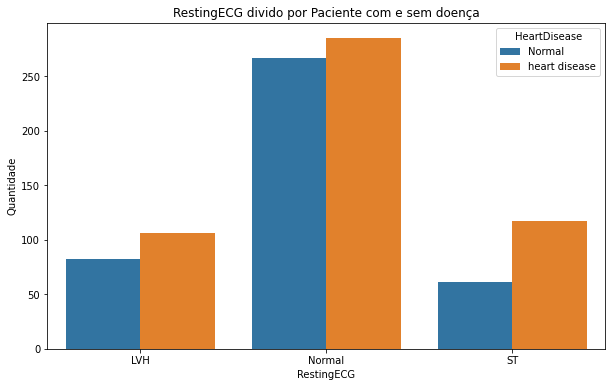

RestingECG     LVH  Normal   ST
HeartDisease                   
Normal          82     267   61
heart disease  106     285  117
p-valor : 0.0042292328167544925
Rejeita a hipótese nula, as proporções não são iguais RestingECG


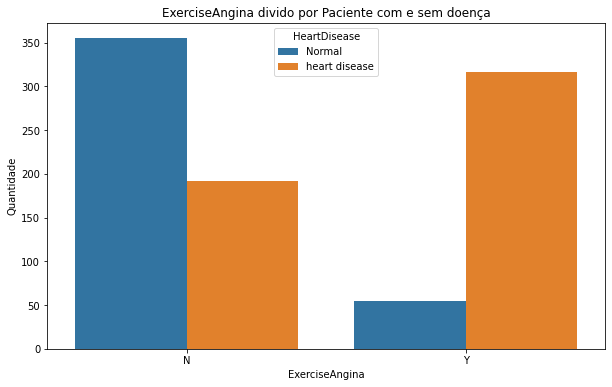

ExerciseAngina    N    Y
HeartDisease            
Normal          355   55
heart disease   192  316
p-valor : 2.907808387659878e-50
Rejeita a hipótese nula, as proporções não são iguais ExerciseAngina


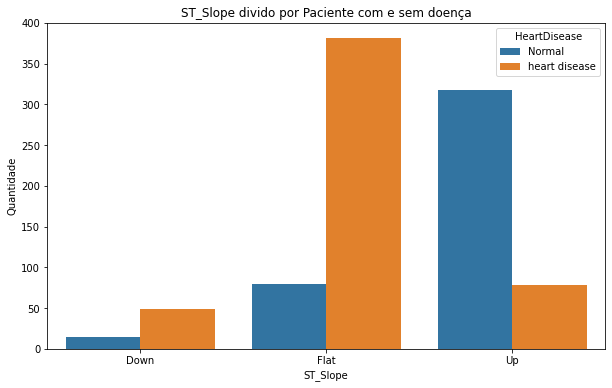

ST_Slope       Down  Flat   Up
HeartDisease                  
Normal           14    79  317
heart disease    49   381   78
p-valor : 5.167637689470128e-78
Rejeita a hipótese nula, as proporções não são iguais ST_Slope


In [19]:
for col in categorical_columns:
    print_cat = df1.groupby([col, 'HeartDisease'], as_index=False).count()
    sns.barplot(x=col, y='Age', hue='HeartDisease', data=print_cat);
    _add_graph_info(col, 'Quantidade', '{} divido por Paciente com e sem doença'.format(col))
    plt.show()
    
    df_crosstab = pd.crosstab(df1['HeartDisease'], df1[col])
    print(df_crosstab)
    results = (chi2_contingency(df_crosstab))
    print('p-valor :', results[1])
    if results[1] < 0.05:
        print('Rejeita a hipótese nula, as proporções não são iguais', col)
    else:
        print('Aceita a hipótese nula, as proporções são iguais ', col)

<h2> 7. Preparação </h2>

<h3> Separação </h3>

In [20]:
X = df.drop('HeartDisease', axis=1)
y = df[['HeartDisease']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

<h3> Substituição de valores </h3>

In [21]:
X_train['Cholesterol'], median_normal_cholesterol, median_disease_cholesterol = fill_median(X_train, y_train, 'Cholesterol')
X_train['RestingBP'], median_normal_restingbp, median_disease_restingbp = fill_median(X_train, y_train, 'RestingBP')

<h3> Balanceamento </h3>

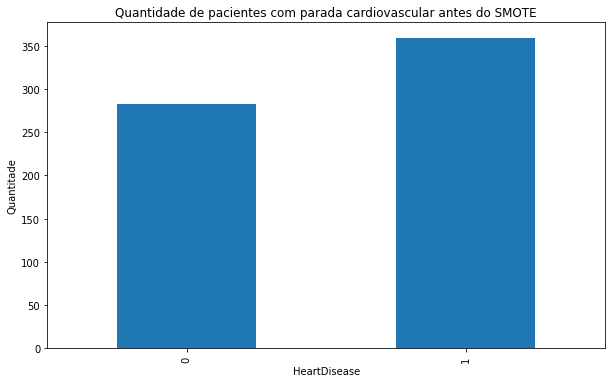

In [22]:
y_train['dropar'] = 1
ax = y_train.groupby('HeartDisease').sum().plot(kind='bar');
ax.get_legend().remove()
_add_graph_info('HeartDisease', 'Quantitade', 'Quantidade de pacientes com parada cardiovascular antes do SMOTE')
y_train.drop(columns=['dropar'], inplace=True)

In [23]:
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train, y_train)

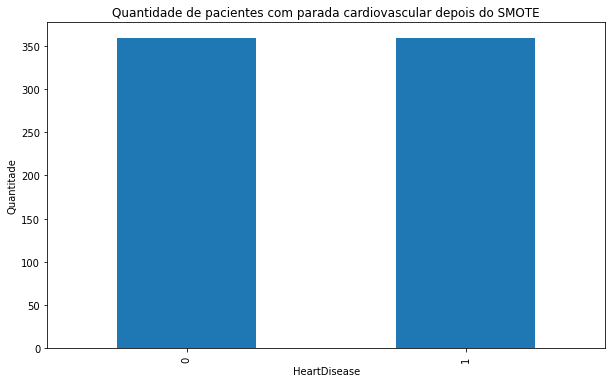

In [24]:
y_train['dropar'] = 1
ax = y_train.groupby('HeartDisease').sum().plot(kind='bar');
ax.get_legend().remove()
_add_graph_info('HeartDisease', 'Quantitade', 'Quantidade de pacientes com parada cardiovascular depois do SMOTE')
y_train.drop(columns=['dropar'], inplace=True)